In [1]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import warnings
warnings.filterwarnings('ignore')


def name_change(name):
    er = name.split('ER')
    he = name.split('He')
    if len(er) > 1:
        return ['ER', er[-1].split('_')[1]]
    elif len(he) > 1:
        return ['He', he[-1].split('_')[1]]
    else:
        return None
    
    
def get_data_from_raw(input_dict):
    x = np.array(input_dict['ROC']['full'])[:, 0, :, :]
    y = np.array(input_dict['ROC']['full'])[:, 1, :, :]
    f1 = (2*x*y)/(x+y)
    f1 = np.nan_to_num(f1)
    result = f1.max(axis=1).ravel()
    n_filters = x.shape[-1]
    table = pd.DataFrame({'path':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_path'])),
                          'image':list(itertools.chain.from_iterable(itertools.repeat(x, n_filters) for x in input_dict['Image_index'])),
                      'filter':input_dict['Filter_name'],
                      'parameter': input_dict['Filter_parameter'],
                      'f1': result})
    table = pd.DataFrame.from_records(table.path.apply(name_change), columns=['particle', 'energy']).join(table.drop('path', axis=1))
    table['parameter'] = table.parameter.apply(lambda x: x[0])
    table.energy = table.energy.astype(np.int)
    table.parameter[table.parameter == 'n'] = 0
    table.parameter = table.parameter.astype(np.int)
    return table

## Carregando resultados

In [2]:
# with open('../data/gaussian.json', 'r') as JSON:
#     json_dict = json.load(JSON)
# gaussian = json.loads(json_dict)    

# with open('../data/mean.json', 'r') as JSON:
#     json_dict = json.load(JSON)
# mean = json.loads(json_dict) 


with open('../data/energy_results.json', 'r') as JSON:
    json_dict = json.load(JSON)
data = json.loads(json_dict)   

In [3]:
result_table = get_data_from_raw(data)

In [4]:
result_table.head(-2)

,particle,energy,image,filter,parameter,f1
0,He,30,pic_run1_ev17,mean,3,0.618436
1,He,30,pic_run1_ev17,mean,7,0.787879
2,He,30,pic_run1_ev17,mean,13,0.911253
3,He,30,pic_run1_ev17,mean,17,0.907623
4,He,30,pic_run1_ev17,mean,21,0.614512
...,...,...,...,...,...,...
1423,He,10,pic_run1_ev87,mean,21,0.490385
1424,He,10,pic_run1_ev87,gaussian,3,0.800518
1425,He,10,pic_run1_ev87,gaussian,7,0.905143
1426,He,10,pic_run1_ev87,gaussian,13,0.903226


## Análise dos resultados
  * Desempenho dos filtros para cada tipo de partícula e valor de energia
  * Reconstrução da curva energia x integral dos clusters

### Análise por valor de Energia

(0.0, 1.0)

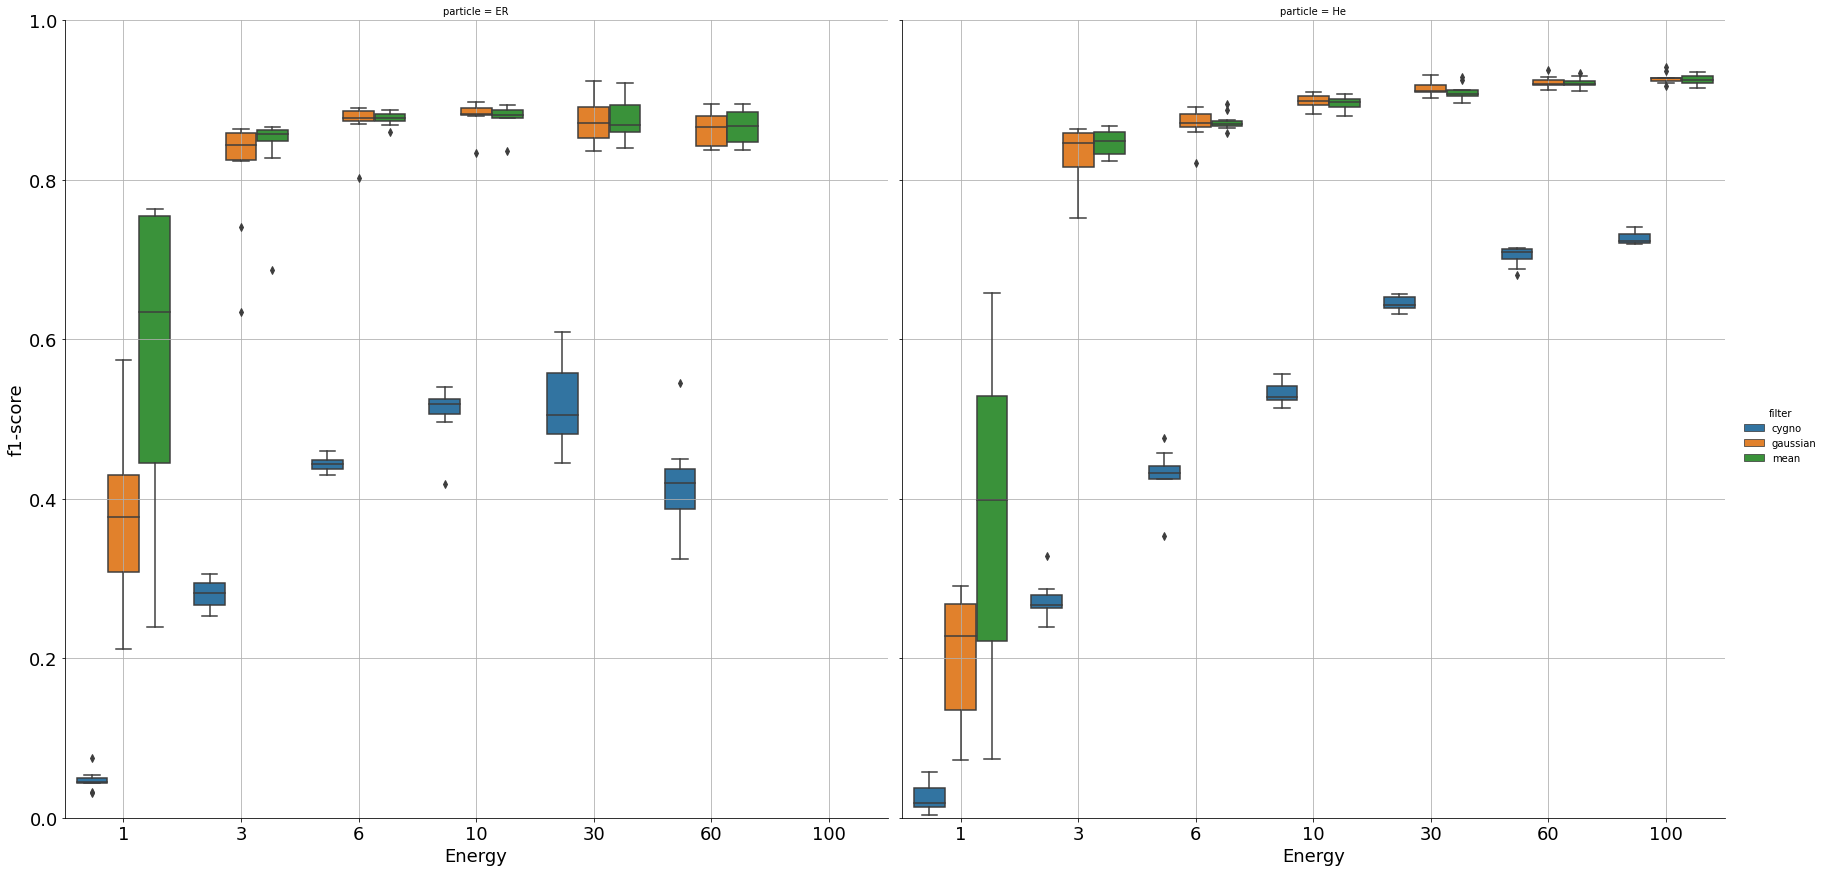

In [29]:
#plt.figure(figsize=(30,15))
g = sns.catplot(x="energy", y="f1", hue="filter", col="particle", data=result_table.groupby(['particle','filter', 'energy', 'image']).agg({'f1':'max'}).reset_index(), kind="box", height=12, aspect=1)
axes = g.axes.ravel()
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel('Energy', fontsize=18)
axes[0].set_ylabel('f1-score', fontsize=18)
axes[1].set_xlabel('Energy', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[0].set_ylim([0, 1])
axes[1].set_ylim([0, 1])

### Reconstrução da energia

In [70]:
energy_table = pd.DataFrame(np.array([data['Image_path'],data['Energy']['image_truth'],data['Energy']['image_real']]).T, columns=['image_path','truth_cluster_integral', 'estimated_cluster_integral'])
energy_table = pd.DataFrame.from_records(energy_table.image_path.apply(name_change), columns=['particle', 'energy']).join(energy_table.drop('image_path', axis=1))
energy_table.truth_cluster_integral = energy_table.truth_cluster_integral.astype(float)
energy_table.estimated_cluster_integral = energy_table.estimated_cluster_integral.astype(float)
energy_table.energy = energy_table.energy.astype(int)
energy_agg = energy_table.groupby(['particle','energy']).agg({'truth_cluster_integral':['mean', 'std'], 'estimated_cluster_integral':['mean', 'std']}).reset_index().sort_values(by=['particle', 'energy'])
energy_agg.columns = energy_agg.columns.map('_'.join).str.strip('_')

In [81]:
energy_table.columns

Index(['particle', 'energy', 'truth_cluster_integral',
       'estimated_cluster_integral'],
      dtype='object')

In [83]:
energy_agg['particle']

0     ER
1     ER
2     ER
3     ER
4     ER
5     ER
6     He
7     He
8     He
9     He
10    He
11    He
12    He
Name: particle, dtype: object

In [100]:
energy_agg

,particle,energy,truth_cluster_integral_mean,truth_cluster_integral_std,estimated_cluster_integral_mean,estimated_cluster_integral_std
0,ER,1,497.8,1.032796,499.478388,46.847811
1,ER,3,1493.4,2.913570,1491.183372,60.079011
2,ER,6,2984.6,4.765618,2951.856196,56.645615
3,ER,10,4963.8,5.808040,5008.771837,84.370942
4,ER,30,14868.5,8.017342,14808.038302,160.505232
5,ER,60,29727.7,27.956514,29797.242578,281.912572
6,He,1,363.8,56.357588,353.002162,63.087163
7,He,3,1414.3,43.029835,1443.449920,62.392594
8,He,6,2777.2,354.037286,2751.831125,352.823293
9,He,10,4925.0,66.048804,4931.652045,98.127680


Text(0.5, 1.0, 'Nucler recoil')

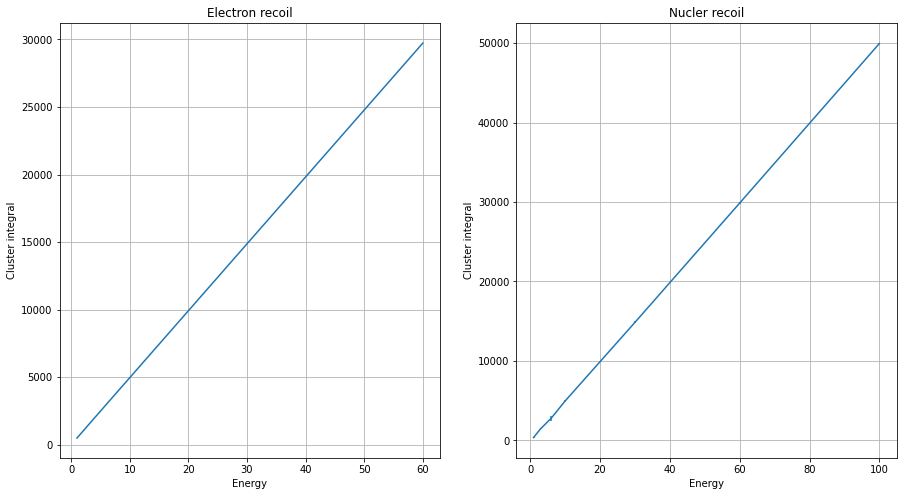

In [107]:
fig, ax =plt.subplots(1, 2,figsize=(15,8))
ax[0].errorbar()
ax[1].errorbar(x = energy_agg[energy_agg['particle']=='He'].energy, y = energy_agg[energy_agg['particle']=='He'].estimated_cluster_integral_mean, yerr=energy_agg[energy_agg['particle']=='He'].estimated_cluster_integral_std)
for axis in ax:
    axis.set_xlabel('Energy')
    axis.set_ylabel('Cluster integral')
ax[0].grid()
ax[1].grid()
ax[0].set_title('Electron recoil')
ax[1].set_title('Nucler recoil')

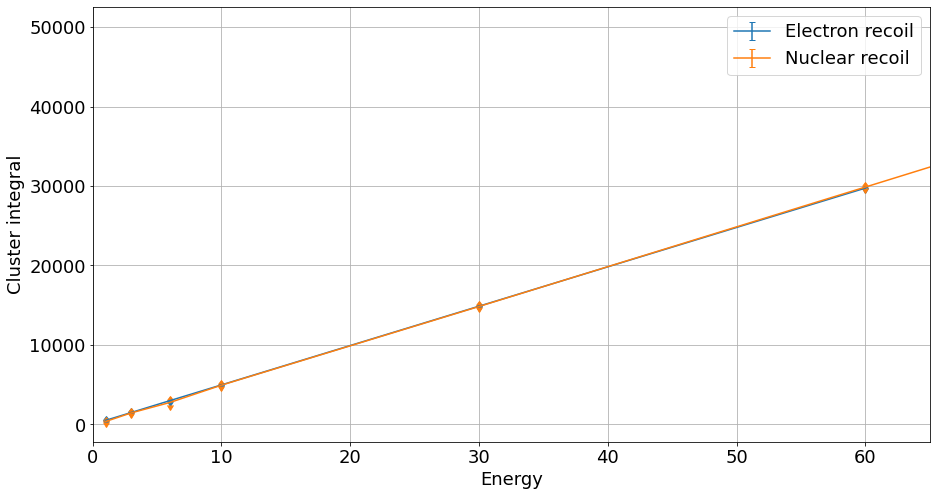

In [123]:
plt.figure(figsize=(15,8))
plt.errorbar(x = energy_agg[energy_agg['particle']=='ER'].energy, y = energy_agg[energy_agg['particle']=='ER'].truth_cluster_integral_mean, yerr=energy_agg[energy_agg['particle']=='ER'].truth_cluster_integral_std, uplims=True, lolims=True,
             label='Electron recoil')
plt.errorbar(x = energy_agg[energy_agg['particle']=='He'].energy, y = energy_agg[energy_agg['particle']=='He'].estimated_cluster_integral_mean, yerr=energy_agg[energy_agg['particle']=='He'].estimated_cluster_integral_std, uplims=True, lolims=True,
             label='Nuclear recoil')
plt.xlim([0, 65])
plt.grid()
plt.xlabel('Energy', fontsize=18)
plt.ylabel('Cluster integral', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)